# LSTM for Anomaly Detection in time series

https://www.renom.jp/notebooks/tutorial/time_series/lstm-anomalydetection/notebook.html

<p class="summary">Anomaly detection of time series using LSTM</p>

 Anomaly detection has applications to many fields, such as system health monitoring, fraud detection, and intrusion detection. Among them, there are two types of anomalies.
![](figures/anomaly_variants.png)
One type of anomaly is known as 'outlier', which is a value located outside of the normal class, as shown on the left side of the figure above. The other type of anomaly is an anomalous behavior, which is a periodic collapsing phenomenon in time series, as shown on the right side of the figure above. Even when an anomalous behavior gets a normal value, it is an anomaly in terms of a periodicity.   
LSTM is the neural network that can be applied to the time-series analysis.   
In this tutorial, we will explain the latter type of anomaly detection using LSTM.

## Algorithm

In this tutorial, we use the anomaly detection algorithm proposed in   
"Long short term memory networks for anomaly detection in time series.",Malhotra, Pankaj, et al, 2015.   
The algorithm consists of three steps.

### STEP1

Train LSTM to predict the next $l$ values $\{x_{t+1},\ldots,x_{t+l}\}$ from the previous $d$ data $\{x_{t-d+1},\ldots,x_{t}\}$. The figure below represents the case of $d=2, l=1$.   
When using the time series $\{x_1,\ldots,x_T\}$, the input of LSTM is a sequence of $M$ dimensional vectors $\{x_{t-d+1},\ldots,x_{t}\}$ and the output is $l$ vectors of $M$ dimensional vector $\{x_{t+1},\ldots,x_{t+l}\}$ which is predicted at once.

### STEP2
 
Compute error vectors :

$$
e = x_{{\rm true}} - x_{{\rm pred}}
$$

using the trained LSTM. $x_{{\rm true}},x_{{\rm pred}}$ are the observed value and the predicted value respectively. Then, we fit a multivariate Gaussian distribution to error vectors computed over test data by the maximum likelihood estimation.

### STEP3

Compute the error vector at the point where an anomaly is likely to have happened. If that vector is located at the end of the Gaussian distribution estimated in STEP2, conclude an anomaly happened.   
Suppose we want to detect an anomaly at point A in the figure below.
When the error vector is located at the end of the distribution, something anomalous was likely to have happened at that point. We can assume

**Rare error vector occurred ⇒ Probability distribution of data has changed from normal to anomalous**

![](figures/althm.png)

## Mahalanobis' Distance

As discussed in the previous chapter, we can measure the rarity of the event with the location in the distribution. The Mahalanobis' distance is statistics representing an anomaly score. Assuming the parameters of an $M$ dimensional Gaussian distribution are estimated as follows

$$
p(x|{\rm Data}) = N(x|\widehat{\mu},\widehat{\sum}).
$$

Then, the Mahalanobis' distance is defined

$$
a(x) = (x-\widehat{\mu})^\top \widehat{\sum}^{-1}(x-\widehat{\mu}).
$$

We can measure the rarity of the event with $a(x)$.

## Required Libraries

- ReNom 2.6.2
- matplotlib 2.2.2
- pandas 0.23.1
- numpy 1.14.5
- scikit-learn 0.19.1
- scipy 1.1.0

In [102]:
# Install ReNom https://giters.com/muhamuttaqien/ReNom
!git clone https://github.com/ReNom-dev-team/ReNom.git
%cd /content/ReNom
#!python setup.py build_ext -if
!pip install -e .

fatal: destination path 'ReNom' already exists and is not an empty directory.
/content/ReNom
Obtaining file:///content/ReNom
  Using cached numpy-1.15.4-cp37-cp37m-manylinux1_x86_64.whl (13.8 MB)
  Using cached scikit_image-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (25.3 MB)
  Using cached scikit_learn-0.20.2-cp37-cp37m-manylinux1_x86_64.whl (5.4 MB)
  Using cached Cython-0.27.3.tar.gz (1.8 MB)
  Using cached Pillow-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
  Using cached pandas-0.21.1.tar.gz (11.3 MB)
  Installing build dependencies ... error
ERROR: Could not find a version that satisfies the requirement pandas==0.21.1 (from renom) (from versions: 0.1, 0.2, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0, 0.21.1, 0

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
set_cuda_active(False)

## Loading Data

We will use ECG dataset, qtdb/sel102 ECG dataset [2].

It can be downloaded from

http://www.cs.ucr.edu/~eamonn/discords/



## Preprocessing

Firstly, we will standardize ECG data and plot a part of it (0~5000 time) to see the structure.

/content
length of ECG data :  45036


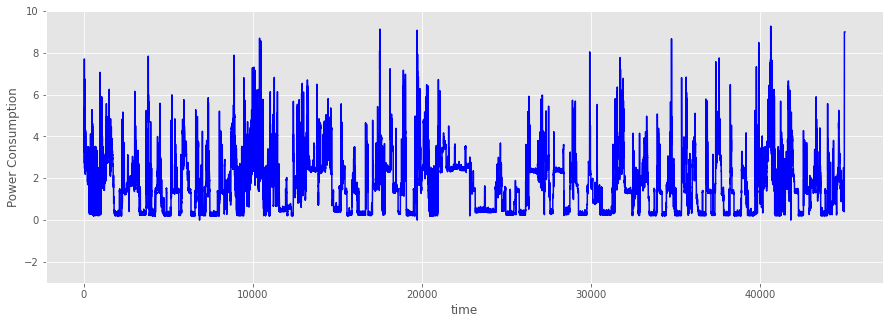

In [106]:
%cd /content

#df = pd.read_csv('data/qtdbsel102.txt', header=None, delimiter='\t')
df = pd.read_csv('data/household_power_consumption.txt', header=None, delimiter='\t')
ecg = df.iloc[:,1].values
ecg = ecg.reshape(len(ecg), -1)
print('length of ECG data : ', len(ecg))

# standardize
#scaler = StandardScaler()
#std_ecg = scaler.fit_transform(ecg)
std_ecg = ecg

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Power Consumption')
plt.plot(np.arange(45036), std_ecg[:45036], color='b')
plt.ylim(-3, 10)
#x = np.arange(4200,4400)
#y1 = [-3]*len(x)
#y2 = [3]*len(x)
#plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
plt.show()

As shown in the graph above, this data is periodic. We can also observe that there is a change point at around time 4250 because the periodicity is collapsing at around there. Since the aim of STEP1 is to get LSTM learned from normal data, we will use data after time 5000 as training data.

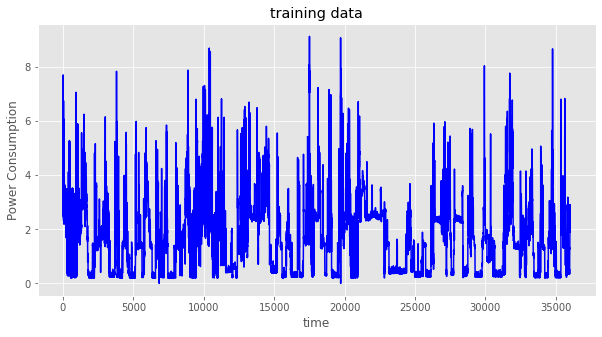

In [107]:
normal_cycle = std_ecg[:36028]

plt.figure(figsize=(10,5))
plt.title("training data")
plt.xlabel('time')
plt.ylabel('Power Consumption')
plt.plot(np.arange(0, 36028), normal_cycle[:36028], color='b')# stop plot at 8000 times for friendly visual
plt.show()

Secondly, we will define the function which creates sets of a subsequence of $d$ length and a label of $l$ dimension as follows.

In [108]:
# create data of the "look_back" length from time-series, "ts"
# and the next "pred_length" values as labels
def create_subseq(ts, look_back, pred_length):
    sub_seq, next_values = [], []
    for i in range(len(ts)-look_back-pred_length):  
        sub_seq.append(ts[i:i+look_back])
        next_values.append(ts[i+look_back:i+look_back+pred_length].T[0])
    return sub_seq, next_values

In this tutorial, we will set $d=10, l=3$.

In [109]:
look_back = 10
pred_length = 3

sub_seq, next_values = create_subseq(normal_cycle, look_back, pred_length)


X_train, X_test, y_train, y_test = train_test_split(
    sub_seq, next_values, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


train_size = X_train.shape[0]
test_size = X_test.shape[0]
print('train size:{}, test size:{}'.format(train_size, test_size))

train size:28812, test size:7203


## Model Definition

In [110]:
# model definition
model = rm.Sequential([
    rm.Lstm(35),
    rm.Relu(),
    rm.Lstm(35),
    rm.Relu(),
    rm.Dense(pred_length)
    ])

## Parameters Setting

In [111]:
# params
batch_size = 100
max_epoch = 50 #2000
period = 10 # early stopping checking period
optimizer = Adam()

## Train Loop（STEP1）

epoch:10 train loss:0.3731967059171034 test loss:0.34590083360671997
epoch:20 train loss:0.3393064482758443 test loss:0.3205413222312927
epoch:30 train loss:0.321727654689716 test loss:0.30310940742492676
epoch:40 train loss:0.30404672445729375 test loss:0.2989661693572998
epoch:50 train loss:0.2914195917546749 test loss:0.2806395888328552


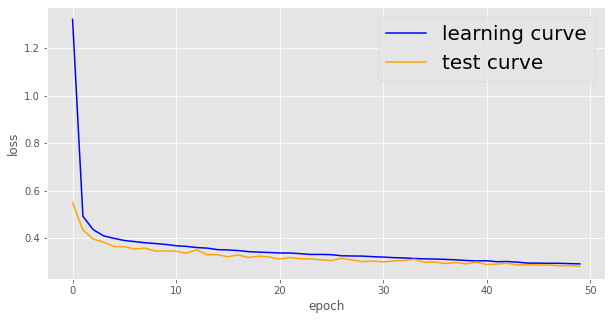

In [112]:
# Train Loop
epoch = 0
loss_prev = np.inf

learning_curve, test_curve = [], []

while(epoch < max_epoch):
    epoch += 1

    perm = np.random.permutation(train_size)
    train_loss = 0

    for i in range(train_size // batch_size):
        batch_x = X_train[perm[i*batch_size:(i+1)*batch_size]]
        batch_y = y_train[perm[i*batch_size:(i+1)*batch_size]]

        # Forward propagation
        l = 0
        z = 0
        with model.train():
            for t in range(look_back):
                z = model(batch_x[:,t])
                l = rm.mse(z, batch_y)
            model.truncate()
        l.grad().update(optimizer)
        train_loss += l.as_ndarray()

    train_loss /= (train_size // batch_size)
    learning_curve.append(train_loss)

    # test
    l = 0
    z = 0
    for t in range(look_back):
        z = model(X_test[:,t])
        l = rm.mse(z, y_test)
    model.truncate()
    test_loss = l.as_ndarray()
    test_curve.append(test_loss)

    # check early stopping
    if epoch % period == 0:
        print('epoch:{} train loss:{} test loss:{}'.format(epoch, train_loss, test_loss))
        if test_loss > loss_prev*0.99:
            print('Stop learning')
            break
        else:
            loss_prev = deepcopy(test_loss)

plt.figure(figsize=(10,5))
plt.plot(learning_curve, color='b', label='learning curve')
plt.plot(test_curve, color='orange', label='test curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(fontsize=20)
plt.show()

As we can see in the figure above, the learning of LSTM has converged. Next, we go to STEP2, fitting an $M$ dimensional Gaussian distribution to error vectors.

## Fitting an $M$ dimensional Gaussian distribution（STEP2）

It's well known that the maximum likelihood estimator of a Gaussian distribution can be computed as

$$
\widehat{\mu} = \frac{1}{N}\sum_{n=1}^{N}x^{(n)}\\
\widehat{\sum} = \frac{1}{N}\sum_{n=1}^{N}(x^{(n)}-\widehat{\mu})(x^{(n)}-\widehat{\mu})^{\top}
$$

In [113]:
# computing errors
for t in range(look_back):
    pred = model(X_test[:,t])
model.truncate()
errors = y_test - pred

mean = sum(errors)/len(errors)

cov = 0
for e in errors:
    cov += np.dot((e-mean).reshape(len(e), 1), (e-mean).reshape(1, len(e)))
cov /= len(errors)

print('mean : ', mean)
print('cov : ', cov)

mean :  [0.0351593  0.00953482 0.01503447]
cov :  [[0.113956   0.08871703 0.06160361]
 [0.08871703 0.20120609 0.15534538]
 [0.06160361 0.15534538 0.24456286]]


## Anomaly Detection (STEP3)

We will verify if this algorithm works even for unknown data.   
Firstly, we will create sets of a subsequence and a label. Then we will compute error vectors in the same manner.

In [114]:
# calculate Mahalanobis distance
def Mahala_distantce(x,mean,cov):
    d = np.dot(x-mean,np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

# anomaly detection
sub_seq, next_values = create_subseq(std_ecg[:45036], look_back, pred_length)
sub_seq = np.array(sub_seq)
next_values = np.array(next_values)

for t in range(look_back):
    pred = model(sub_seq[:,t])
model.truncate()
errors = next_values - pred

Secondly, we will plot the Mahalanobis' distance for each error vector and corresponding ECG data.

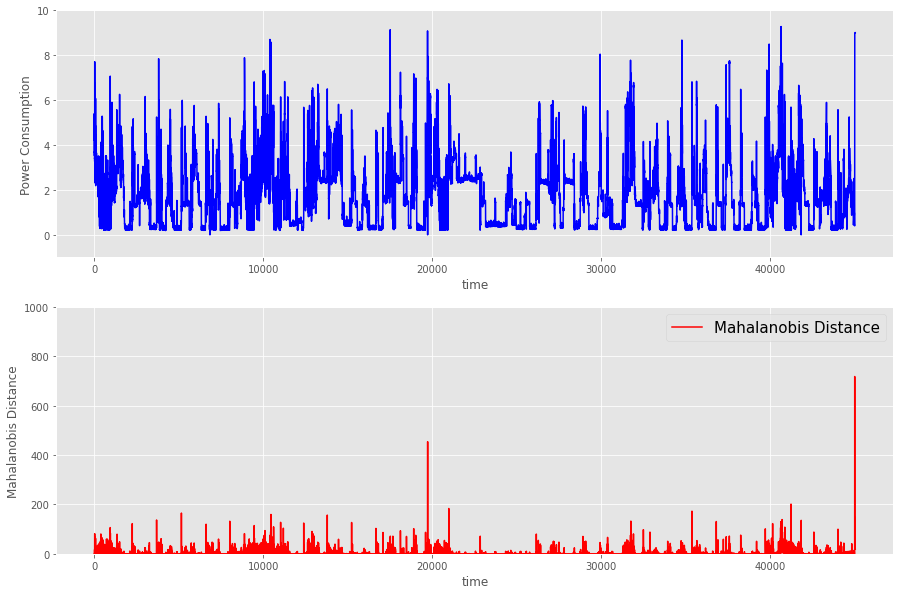

In [116]:
m_dist = [0]*look_back 

for e in errors:
    m_dist.append(Mahala_distantce(e,mean,cov))

fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:45036],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('Power Consumption' )
axes[0].set_ylim(-1, 10)
#x = np.arange(4200,4400)
#y1 = [-3]*len(x)
#y2 = [3]*len(x)
#axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_ylim(0, 1000)
#y1 = [0]*len(x)
#y2 = [1000]*len(x)
#axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()

As we can see in the figure above, the Mahalanobis' distance (a measure of rarity) got large at around time 4250 compared to other parts. As we saw in the preprocessing part, this data has the periodicity collapsing point at around time 4250. As a result, we were able to detect the anomaly.

## Conclusion

We explained the anomaly detection algorithm for time series data using LSTM. As shown in the experiment part, we were able to find the anomaly by rarity, in other words, the location in the distribution.

## References

[1] Malhotra, Pankaj, et al. "Long short term memory networks for anomaly detection in time series." Proceedings. Presses universitaires de Louvain, 2015.


[2]E. Keogh, J. Lin and A. Fu (2005). HOT SAX: Efficiently Finding the Most Unusual Time Series Subsequence. In The Fifth IEEE International Conference on Data Mining.

[3] 井手剛, 杉山将. 『機械学習プロフェッショナルシリーズ　異常検知と変化検知』, 講談社, 2015.